In [1]:
import pandas as pd
import numpy as np
from datetime import *
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df = pd.concat([pd.read_csv("data/lichess_swiss_rating_histories_1.csv",parse_dates=['date']),
                pd.read_csv("data/lichess_swiss_rating_histories_2.csv",parse_dates=['date'])])
print(df.shape)
df.head()

(8623368, 4)


,user_id,time_control,date,rating
0,0,Blitz,2019-01-04,2244
1,0,Blitz,2019-01-05,2256
2,0,Blitz,2019-01-06,2231
3,0,Blitz,2019-01-08,2307
4,0,Blitz,2019-01-29,2288


In [3]:
df['user_id'].nunique()

17171

In [4]:
df['date'].max()

Timestamp('2021-08-03 00:00:00')

In [5]:
# The latest date we have data on
max_outcome_date = df['date'].max()
# The latest date that can be used for training to ensure we'll always have 2 years in advance of outcomes data
max_training_date = max_outcome_date - timedelta(days=365*2)
max_outcome_date,max_training_date

(Timestamp('2021-08-03 00:00:00'), Timestamp('2019-08-04 00:00:00'))

In [6]:
# The earliest date we have data on
minn_training_date = df['date'].min()
minn_training_date

Timestamp('2019-01-01 00:00:00')

In [7]:
# The latest ratings that can be used for training
df_training = df.query('date<=@max_training_date')
df_outcomes = df.query('date>@max_training_date')
latest_training_ratings = df_training.sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
latest_training_ratings.sample(5)

,user_id,time_control,date,rating
2120405,4816,Blitz,2019-06-05,1163
551257,11176,Classical,2019-06-13,884
2171164,14295,Bullet,2019-07-14,1909
3801684,8285,Blitz,2019-07-27,1381
3721104,8116,Bullet,2019-07-30,1545


# Feature Engineering

In [8]:
# Ratings from X days before the max training date
max_training_date_minus_30 = max_training_date-timedelta(days=30)
max_training_date_minus_90 = max_training_date-timedelta(days=90)
max_training_date_minus_180 = max_training_date-timedelta(days=180)
hist_ratings_30 = df.query('date<=@max_training_date_minus_30').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_90 = df.query('date<=@max_training_date_minus_90').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_180 = df.query('date<=@max_training_date_minus_180').sort_values("date",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_180.head()

,user_id,time_control,date,rating
7033,10091,Blitz,2019-02-05,1106
1488095,13023,Rapid,2019-02-05,1339
1475936,12996,Bullet,2019-02-05,1722
1476181,12996,Rapid,2019-02-05,1812
1476463,12997,Bullet,2019-02-05,1454


In [9]:
# Peak ratings
hist_ratings_peak = df_training.sort_values("rating",ascending=False).drop_duplicates(['user_id','time_control'])
outcome_ratings_peak = df_outcomes.sort_values("rating",ascending=False).drop_duplicates(['user_id','time_control'])
hist_ratings_peak.head()

,user_id,time_control,date,rating
3141002,6935,Bullet,2019-03-26,2872
4478689,9624,Bullet,2019-07-21,2852
2810666,6252,Bullet,2019-06-26,2847
4478286,9624,Blitz,2019-08-04,2833
3039334,6727,Bullet,2019-05-05,2832


In [10]:
# Add features to base table
df_base = latest_training_ratings.merge(hist_ratings_30[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control'],suffixes=['_latest','_30']).merge(
            hist_ratings_90[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control']).merge(
            hist_ratings_180[['user_id','time_control','rating']],
                how='left',on=['user_id','time_control'],suffixes=['_90','_180']).merge(
            hist_ratings_peak[['user_id','time_control','rating']].rename(columns={'rating':'rating_peak'}),
                how='left',on=['user_id','time_control'])
df_base['rating_30_diff'] = df_base['rating_latest']-df_base['rating_30']
df_base['rating_90_diff'] = (df_base['rating_latest']-df_base['rating_90']).combine_first(df_base['rating_30_diff'])
df_base['rating_180_diff'] = (df_base['rating_latest']-df_base['rating_180']).combine_first(df_base['rating_90_diff'])
df_base['rating_peak_diff'] = df_base['rating_latest']-df_base['rating_peak']
df_base['time_control_copy'] = df_base['time_control']
df_base['rating_latest_rounded'] = df_base['rating_latest'].round(-2)
df_base['rating_latest_squared'] = df_base['rating_latest']**2
df_base = pd.get_dummies(df_base,columns=['time_control_copy'],prefix_sep="")
df_base.columns = [x.replace("time_control_copy","").lower() for x in df_base.columns]
print(df_base.shape)
df_base.sample(10)

(41530, 18)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,rating_180_diff,rating_peak_diff,rating_latest_rounded,rating_latest_squared,blitz,bullet,classical,rapid
23691,11829,Blitz,2019-07-06,1862,1936.0,1936.0,NaN,1936,-74.0,-74.0,-74.0,-74,1900,3467044,1,0,0,0
19803,14489,Classical,2019-07-19,1607,1582.0,1505.0,1612.0,1636,25.0,102.0,-5.0,-29,1600,2582449,0,0,1,0
28540,9374,Rapid,2019-06-10,1318,1318.0,NaN,NaN,1318,0.0,0.0,0.0,0,1300,1737124,0,0,0,1
3764,3391,Bullet,2019-08-04,2226,2203.0,2191.0,2191.0,2260,23.0,35.0,35.0,-34,2200,4955076,0,1,0,0
41197,7206,Bullet,2019-01-07,1091,1091.0,1091.0,1091.0,1101,0.0,0.0,0.0,-10,1100,1190281,0,1,0,0
23655,9737,Classical,2019-07-06,1178,1193.0,1167.0,1194.0,1248,-15.0,11.0,-16.0,-70,1200,1387684,0,0,1,0
30593,11121,Blitz,2019-05-25,1674,1674.0,1670.0,1687.0,1696,0.0,4.0,-13.0,-22,1700,2802276,1,0,0,0
13403,8128,Rapid,2019-07-31,2041,NaN,NaN,NaN,2041,NaN,NaN,NaN,0,2000,4165681,0,0,0,1
17516,4070,Classical,2019-07-25,1177,1164.0,1136.0,NaN,1177,13.0,41.0,41.0,0,1200,1385329,0,0,1,0
40259,1122,Rapid,2019-01-25,1503,1503.0,1503.0,1503.0,1503,0.0,0.0,0.0,0,1500,2259009,0,0,0,1


In [11]:
# Filter to people who have played rated games in the time control before 30 days ago...
# ... and have played at least one rated game in the time control within the last 30 days
df_base = df_base[(df_base['rating_30'].notna())&(df_base['date']>=max_training_date_minus_30)]
df_base.shape

(21641, 18)

In [12]:
# What is the distribution of rating gains over the two year period?
## Use this to come up with reasonable target rating ranges where I'll have a decent sample size to work with when estimating how long it'll take
df_max_rating_gains = df_base.merge(outcome_ratings_peak,on=['user_id','time_control'],how='inner')
df_max_rating_gains['max_gain'] = df_max_rating_gains['rating']-df_max_rating_gains['rating_latest']
df_max_rating_gains['rating_bucket'] = df_max_rating_gains['rating_latest'].apply(lambda x: 1 if x < 1550 else (2 if x < 1900 else 3))
df_max_rating_gains.groupby("rating_bucket")['max_gain'].describe(percentiles=[.25,.5,.75,.9,.95,.99])

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
rating_bucket,,,,,,,,,,,
1,8044.0,363.515540,206.314120,-244.0,222.00,340.0,484.0,639.0,739.85,936.00,1531.0
2,8356.0,260.590833,128.532018,-161.0,176.00,253.0,336.0,426.0,485.00,620.45,867.0
3,5144.0,205.080288,100.075433,-249.0,138.75,199.0,268.0,331.7,376.00,475.00,618.0


In [13]:
# Generate target ratings
df_targets = pd.concat([df_base for x in range(5)])
def get_target_rating_gain(x):
    die = np.random.randint(1,4)
    if die == 1:
        return np.random.randint(1,100)
    elif die == 2:
        return np.random.randint(1,300)
    elif die == 3:
        if x < 1550:
            return np.random.randint(1,650)
        elif x < 1900:
            return np.random.randint(1,450)
        else:
            return np.random.randint(1,350)
    else:
        print(1/0)

df_targets['target_rating_gain'] = df_targets['rating_latest'].apply(get_target_rating_gain)
df_targets['target_rating'] = df_targets['rating_latest'] + df_targets['target_rating_gain']
df_targets['target_rating_gain_rounded'] = df_targets['target_rating_gain'].round(-2)
df_targets['target_rating_gain_squared'] = df_targets['target_rating_gain']**2
print(df_targets.shape)
df_targets.head()

(108205, 22)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,...,rating_latest_rounded,rating_latest_squared,blitz,bullet,classical,rapid,target_rating_gain,target_rating,target_rating_gain_rounded,target_rating_gain_squared
0,4250,Blitz,2019-08-04,1615,1505.0,1525.0,1555.0,1636,110.0,90.0,...,1600,2608225,1,0,0,0,170,1785,200,28900
1,10683,Blitz,2019-08-04,1216,1109.0,1031.0,NaN,1216,107.0,185.0,...,1200,1478656,1,0,0,0,77,1293,100,5929
2,10440,Blitz,2019-08-04,1433,1522.0,1414.0,1234.0,1598,-89.0,19.0,...,1400,2053489,1,0,0,0,297,1730,300,88209
3,10837,Bullet,2019-08-04,1604,1606.0,NaN,NaN,1761,-2.0,-2.0,...,1600,2572816,0,1,0,0,88,1692,100,7744
4,15733,Blitz,2019-08-04,1156,1253.0,NaN,NaN,1253,-97.0,-97.0,...,1200,1336336,1,0,0,0,93,1249,100,8649


In [14]:
df_targets.groupby("rating_latest_rounded")['target_rating_gain'].describe().round()

,count,mean,std,min,25%,50%,75%,max
rating_latest_rounded,,,,,,,,
600,20.0,218.0,202.0,1.0,62.0,190.0,284.0,619.0
700,30.0,159.0,165.0,3.0,54.0,96.0,174.0,637.0
800,460.0,185.0,172.0,1.0,53.0,116.0,270.0,641.0
900,1075.0,174.0,168.0,1.0,52.0,98.0,252.0,647.0
1000,2435.0,176.0,167.0,1.0,48.0,103.0,262.0,646.0
1100,3845.0,175.0,165.0,1.0,53.0,103.0,255.0,649.0
1200,5870.0,172.0,164.0,1.0,50.0,99.0,254.0,649.0
1300,6690.0,175.0,167.0,1.0,50.0,102.0,258.0,649.0
1400,9140.0,176.0,166.0,1.0,50.0,104.0,256.0,649.0


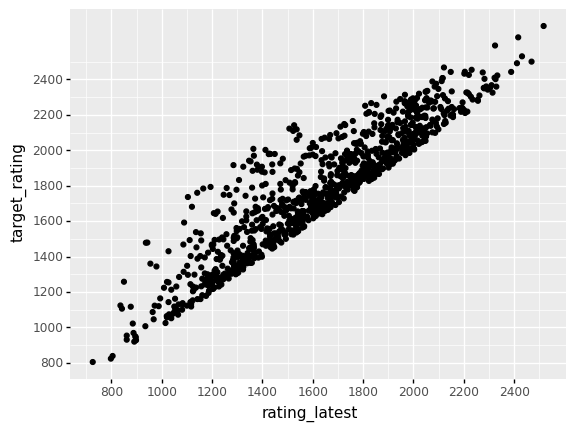

<ggplot: (8785248928982)>

In [15]:
(ggplot(df_targets.sample(1000),aes(x='rating_latest',y='target_rating')) +
 geom_point() +
 scale_x_continuous(breaks=list(range(800,2500,200))) +
  scale_y_continuous(breaks=list(range(800,2500,200)))

        
       )

In [16]:
df_temp = df_targets.copy()
df_temp = df_temp.merge(df_outcomes,on=['user_id','time_control'],how='outer',suffixes=['_latest','_future'])
df_temp.head()

,user_id,time_control,date_latest,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,...,blitz,bullet,classical,rapid,target_rating_gain,target_rating,target_rating_gain_rounded,target_rating_gain_squared,date_future,rating
0,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,110.0,90.0,...,1.0,0.0,0.0,0.0,170.0,1785.0,200.0,28900.0,2019-08-05,1598.0
1,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,110.0,90.0,...,1.0,0.0,0.0,0.0,170.0,1785.0,200.0,28900.0,2019-08-06,1630.0
2,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,110.0,90.0,...,1.0,0.0,0.0,0.0,170.0,1785.0,200.0,28900.0,2019-08-07,1626.0
3,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,110.0,90.0,...,1.0,0.0,0.0,0.0,170.0,1785.0,200.0,28900.0,2019-08-08,1654.0
4,4250,Blitz,2019-08-04,1615.0,1505.0,1525.0,1555.0,1636.0,110.0,90.0,...,1.0,0.0,0.0,0.0,170.0,1785.0,200.0,28900.0,2019-08-09,1644.0


In [17]:
# Successes - filter to where future rating >= target rating, then take earliest date for each user/time control
df_successes = df_temp.query('rating>=target_rating').sort_values("date_future").drop_duplicates(['user_id','time_control','target_rating'])
print(df_successes.shape)
df_successes.sample(5)

(81051, 24)


,user_id,time_control,date_latest,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,...,blitz,bullet,classical,rapid,target_rating_gain,target_rating,target_rating_gain_rounded,target_rating_gain_squared,date_future,rating
7431458,11459,Rapid,2019-08-04,1742.0,1707.0,1544.0,1544.0,1774.0,35.0,198.0,...,0.0,0.0,0.0,1.0,32.0,1774.0,0.0,1024.0,2019-08-27,1775.0
9333375,8865,Blitz,2019-08-04,1658.0,1646.0,1502.0,1223.0,1661.0,12.0,156.0,...,1.0,0.0,0.0,0.0,99.0,1757.0,100.0,9801.0,2020-02-04,1762.0
22131236,4292,Blitz,2019-07-13,1361.0,1432.0,1259.0,1236.0,1487.0,-71.0,102.0,...,1.0,0.0,0.0,0.0,42.0,1403.0,0.0,1764.0,2019-08-24,1414.0
20369104,16728,Blitz,2019-07-23,915.0,868.0,868.0,854.0,923.0,47.0,47.0,...,1.0,0.0,0.0,0.0,25.0,940.0,0.0,625.0,2019-08-19,986.0
21511976,4906,Classical,2019-07-17,1156.0,1182.0,1209.0,1188.0,1562.0,-26.0,-53.0,...,0.0,0.0,1.0,0.0,127.0,1283.0,100.0,16129.0,2019-10-14,1294.0


In [18]:
# Successes and failures 
df_bin = df_targets.merge(df_successes[['user_id','time_control','target_rating','date_future']],on=['user_id','time_control','target_rating'],how='left')
# Was the target rating achieved?
df_bin['y_bin'] = df_bin['date_future'].notna().astype(int)
# If so, when?
df_bin['y_cont'] = (df_bin['date_future']-max_training_date).dt.days
print(df_bin.shape)
df_bin.sample(10)

(108205, 25)


,user_id,time_control,date,rating_latest,rating_30,rating_90,rating_180,rating_peak,rating_30_diff,rating_90_diff,...,bullet,classical,rapid,target_rating_gain,target_rating,target_rating_gain_rounded,target_rating_gain_squared,date_future,y_bin,y_cont
107892,4789,Classical,2019-07-06,1954,1941.0,1923.0,1923.0,1954,13.0,31.0,...,0,1,0,235,2189,200,55225,NaT,0,NaN
72015,12830,Blitz,2019-08-03,1427,1482.0,1314.0,1375.0,1494,-55.0,113.0,...,0,0,0,52,1479,100,2704,2019-10-05,1,62.0
38080,808,Blitz,2019-07-24,1402,1439.0,1184.0,NaN,1510,-37.0,218.0,...,0,0,0,108,1510,100,11664,2019-10-31,1,88.0
4628,10056,Classical,2019-08-04,1658,1591.0,1407.0,NaN,1716,67.0,251.0,...,0,1,0,115,1773,100,13225,2019-08-28,1,24.0
28197,12730,Blitz,2019-08-04,1581,1610.0,1561.0,1473.0,1682,-29.0,20.0,...,0,0,0,64,1645,100,4096,2020-05-14,1,284.0
53897,2964,Blitz,2019-08-01,1872,1851.0,1883.0,1848.0,1911,21.0,-11.0,...,0,0,0,4,1876,0,16,2019-09-25,1,52.0
26106,4830,Bullet,2019-08-04,2185,2065.0,2084.0,2002.0,2236,120.0,101.0,...,1,0,0,13,2198,0,169,2019-08-05,1,1.0
96711,70,Rapid,2019-08-02,1749,1773.0,1631.0,1607.0,1878,-24.0,118.0,...,0,0,1,212,1961,200,44944,2021-02-27,1,573.0
42686,6452,Bullet,2019-07-07,1179,1152.0,1208.0,1243.0,1263,27.0,-29.0,...,1,0,0,93,1272,100,8649,2020-04-19,1,259.0
80187,16276,Blitz,2019-07-26,1243,1318.0,1194.0,1314.0,1318,-75.0,49.0,...,0,0,0,92,1335,100,8464,2020-07-01,1,332.0


In [19]:
df_cont = df_bin[df_bin['y_bin']==1].copy()

# EDA

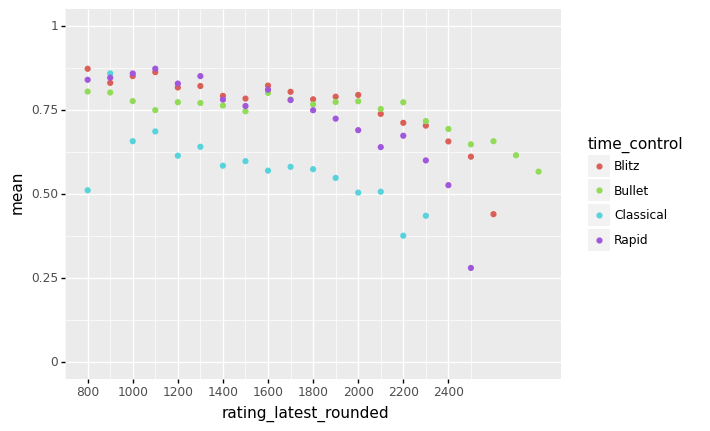

<ggplot: (8785145069358)>

In [20]:
y_bin_by_rating = df_bin.groupby(["rating_latest_rounded","time_control"])['y_bin'].agg([np.mean,len])
(ggplot(y_bin_by_rating[y_bin_by_rating['len']>=25].reset_index(),
        aes(x='rating_latest_rounded',y='mean',color='time_control')) +
 geom_point() +
      scale_x_continuous(breaks=list(range(600,2600,200))) +
         ylim([0,1])
       )

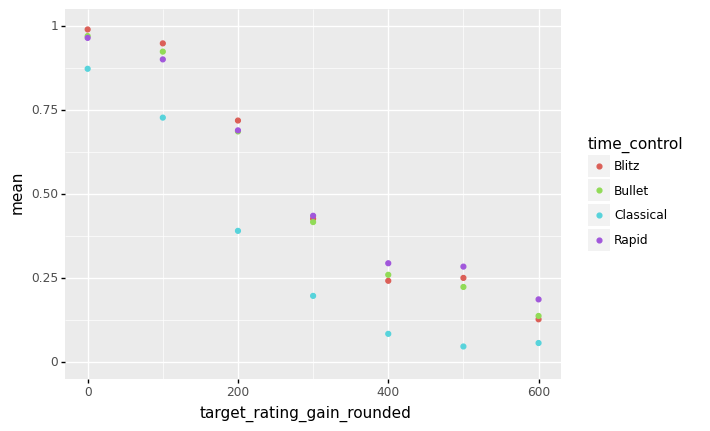

<ggplot: (8783929849920)>

In [62]:
y_bin_by_gain = df_bin.groupby(["target_rating_gain_rounded","time_control"])['y_bin'].agg([np.mean,len])
(ggplot(y_bin_by_gain[y_bin_by_gain['len']>=25].reset_index(),
        aes(x='target_rating_gain_rounded',y='mean',color='time_control')) +
 geom_point() +
         ylim([0,1])
       )

In [75]:
bin_by_quant_vars = df_bin.groupby(['target_rating_gain_rounded','rating_latest_rounded'])['y_bin'].mean().reset_index().round(2)
bin_by_quant_vars.pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded',values='y_bin').iloc[:-2,6:-8]

rating_latest_rounded,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100
target_rating_gain_rounded,,,,,,,,,,
0,0.95,0.97,0.96,0.97,0.97,0.97,0.97,0.97,0.96,0.97
100,0.92,0.94,0.92,0.93,0.92,0.92,0.91,0.90,0.89,0.86
200,0.80,0.82,0.76,0.76,0.70,0.68,0.65,0.60,0.54,0.48
300,0.63,0.67,0.60,0.51,0.45,0.40,0.35,0.26,0.22,0.16
400,0.46,0.41,0.32,0.29,0.19,0.13,0.11,0.08,NaN,NaN


As target rating gain increases, the effect of latest rating should go from zero to more negative.

In [21]:
y_cont_by_rating = df_cont.groupby(["rating_latest_rounded",'time_control'])['y_cont'].agg([np.mean,len]).reset_index()
y_cont_by_rating.head()

,rating_latest_rounded,time_control,mean,len
0,600,Blitz,32.5,10.0
1,600,Bullet,54.8,5.0
2,600,Rapid,255.2,5.0
3,700,Blitz,86.2,15.0
4,700,Bullet,658.0,4.0


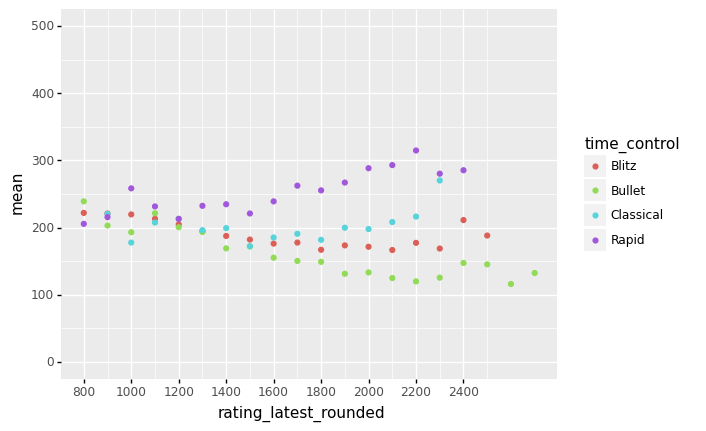

<ggplot: (8785145064183)>

In [22]:
(ggplot(y_cont_by_rating.query('len>=25'),aes(x='rating_latest_rounded',y='mean',color='time_control')) +
        geom_point() +
    ylim(0,500) +
     scale_x_continuous(breaks=list(range(600,2600,200)))
        
       )

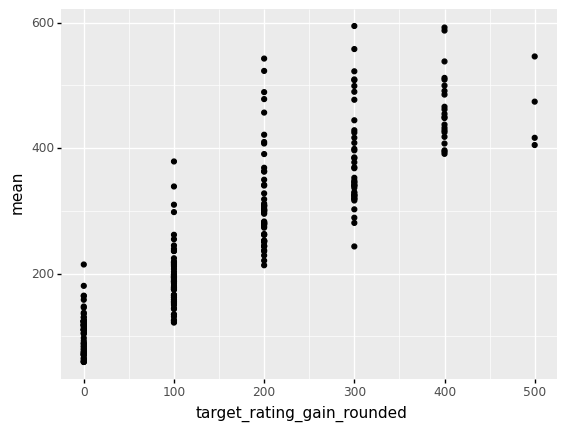

<ggplot: (8783920338128)>

In [23]:
mean_outcome_by_group = df_cont.groupby(['target_rating_gain_rounded','time_control','rating_latest_rounded'])['y_cont'].agg([np.mean,len]).reset_index()
(ggplot(mean_outcome_by_group.query('len>=30'),aes(x='target_rating_gain_rounded',y='mean')) +
      geom_point())

In [24]:
# Outlier checks
## High gains
df_cont['target_rating_gain'].describe(percentiles=[x/10 for x in range(10)])

count    81678.000000
mean       105.741546
std         96.150640
min          1.000000
0%           1.000000
10%         15.000000
20%         30.000000
30%         45.000000
40%         60.000000
50%         76.000000
60%         92.000000
70%        125.000000
80%        178.000000
90%        243.000000
max        647.000000
Name: target_rating_gain, dtype: float64

In [25]:
## Quick gains
df_cont[df_cont['target_rating_gain']>100]['y_cont'].describe(percentiles=[x/10 for x in range(10)])

count    28704.000000
mean       308.802815
std        207.655051
min          1.000000
0%           1.000000
10%         66.000000
20%        111.000000
30%        155.000000
40%        209.000000
50%        255.000000
60%        323.000000
70%        441.000000
80%        540.000000
90%        629.000000
max        730.000000
Name: y_cont, dtype: float64

# Modeling

In [179]:
class_predictors = ['target_rating_gain','rating_latest','blitz','bullet','rapid','rating_peak_diff','rating_180_diff']
df_bin_predictors = sm.add_constant(df_bin[class_predictors])
#logit = sm.Logit(endog=df_bin['y_bin'],exog=df_bin_predictors).fit()
logit = smf.logit(formula="""
y_bin~target_rating_gain*rating_latest*bullet+target_rating_gain*rating_latest*blitz+
target_rating_gain*rating_latest*classical+

rating_peak_diff*target_rating_gain+rating_180_diff*bullet+rating_180_diff*blitz+

target_rating_gain_squared*rating_latest*bullet
""",data=df_bin).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.339508
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_bin   No. Observations:               108205
Model:                          Logit   Df Residuals:                   108180
Method:                           MLE   Df Model:                           24
Date:                Wed, 04 Aug 2021   Pseudo R-squ.:                  0.3904
Time:                        22:04:31   Log-Likelihood:                -36736.
converged:                       True   LL-Null:                       -60265.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           4.6445      0.284     16.332      0.000       4.087       5.202
target_rating_gain                                  0.0012      0.002      0.692      0.489      -0.002       0.005
rating_latest                                      -0.0007      0.000     -4.396      0.000      -0.001      -0.000
target_rating_gain:rating_latest                -1.075e-05   1.06e-06    -10.152      0.000   -1.28e-05   -8.68e-06
bullet                                             -4.3788      0.374    -11.703      0.000      -5.112      -3.645
target_rating_gain:bullet                           0.0135      0.003      5.092      0.000       0.008       0.019
rating_latest:bullet                                0.0028      0.000     12.403      0.000       0.002       0.003
target_rating_gain:rating_latest:bullet         -9.463e-06   1.69e-06     -5.587      0.000   -1.28e-05   -6.14e-06
blitz                                              -0.3365      0.302     -1.116      0.265      -0.928       0.255
target_rating_gain:blitz                        -1.684e-05      0.001     -0.016      0.987      -0.002       0.002
rating_latest:blitz                                 0.0008      0.000      4.725      0.000       0.000       0.001
target_rating_gain:rating_latest:blitz          -2.022e-06   6.72e-07     -3.010      0.003   -3.34e-06   -7.05e-07
classical                                          -3.2315      0.335     -9.654      0.000      -3.888      -2.575
target_rating_gain:classical                        0.0045      0.001      3.124      0.002       0.002       0.007
rating_latest:classical                             0.0011      0.000      5.618      0.000       0.001       0.001
target_rating_gain:rating_latest:classical      -2.911e-06   9.17e-07     -3.173      0.002   -4.71e-06   -1.11e-06
rating_peak_diff                                   -0.0057      0.000    -19.747      0.000      -0.006      -0.005
rating_peak_diff:target_rating_gain              8.951e-06    9.2e-07      9.724      0.000    7.15e-06    1.08e-05
rating_180_diff                                     0.0021      0.000     14.448      0.000       0.002       0.002
rating_180_diff:bullet                             -0.0017      0.000     -8.547      0.000      -0.002      -0.001
rating_180_diff:blitz                              -0.0024      0.000    -11.804      0.000      -0.003      -0.002
target_rating_gain_squared                      -5.965e-06   2.82e-06     -2.117      0.034   -1.15e-05   -4.41e-07
target_rating_gain_squared:rating_latest         9.926e-09   1.89e-09      5.260      0.000    6.23e-09    1.36e-08
target_rating_gain_squared:bullet               -1.797e-05   4.63e-06     -3.883      0.000    -2.7e-05    -8.9e-06
target_rating_gain_squared:rating_latest:bullet  1.262e-08   3.21e-09      3.927      0.000    6.32e-09    1.

In [27]:
# Regression
regress_predictors = ['target_rating_gain','rating_latest','blitz','bullet','rapid','rating_peak_diff','rating_90_diff']
df_cont_predictors = sm.add_constant(df_cont[regress_predictors])
#ols = sm.OLS(endog=df_cont['y_cont'],exog=df_cont_predictors).fit()
ols = smf.ols(formula="""
y_cont~target_rating_gain_squared+
target_rating_gain*bullet+target_rating_gain*blitz+target_rating_gain*classical+
rating_latest_squared+
rating_latest*bullet+rating_latest*blitz+rating_latest*classical+
rating_peak_diff*bullet+rating_peak_diff*blitz+rating_peak_diff*classical+
rating_90_diff*bullet+rating_90_diff*blitz+rating_90_diff*classical

""",data=df_cont).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_cont   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1960.
Date:                Wed, 04 Aug 2021   Prob (F-statistic):               0.00
Time:                        20:49:11   Log-Likelihood:            -5.2994e+05
No. Observations:               81678   AIC:                         1.060e+06
Df Residuals:                   81656   BIC:                         1.060e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      175.8723     13.404     13.121      0.000     149.600     202.144
target_rating_gain_squared      -0.0014   3.66e-05    -38.913      0.000      -0.001      -0.001
target_rating_gain               1.7143      0.019     91.885      0.000       1.678       1.751
bullet                         251.1220     10.072     24.933      0.000     231.381     270.863
target_rating_gain:bullet       -0.3156      0.016    -19.302      0.000      -0.348      -0.284
blitz                          149.3226      9.827     15.196      0.000     130.062     168.583
target_rating_gain:blitz        -0.0314      0.015     -2.036      0.042      -0.062      -0.001
classical                       87.0778     16.059      5.422      0.000      55.602     118.554
target_rating_gain:classical    -0.2835      0.027    -10.579      0.000      -0.336      -0.231
rating_latest_squared         9.234e-05   4.09e-06     22.554      0.000    8.43e-05       0.000
rating_latest                   -0.1911      0.014    -13.596      0.000      -0.219      -0.164
rating_latest:bullet            -0.1780      0.005    -32.688      0.000      -0.189      -0.167
rating_latest:blitz             -0.1228      0.005    -23.182      0.000      -0.133      -0.112
rating_latest:classical         -0.0587      0.009     -6.615      0.000      -0.076      -0.041
rating_peak_diff                 0.3073      0.018     16.701      0.000       0.271       0.343
rating_peak_diff:bullet          0.1094      0.023      4.725      0.000       0.064       0.155
rating_peak_diff:blitz           0.1112      0.022      5.009      0.000       0.068       0.155
rating_peak_diff:classical      -0.0937      0.033     -2.806      0.005      -0.159      -0.028
rating_90_diff                  -0.1079      0.015     -7.435      0.000      -0.136      -0.079
rating_90_diff:bullet            0.0017      0.018      0.095      0.924      -0.034       0.038
rating_90_diff:blitz             0.0655      0.018      3.694      0.000       0.031       0.100
rating_90_diff:classical        -0.0650      0.025     -2.607      0.009      -0.114      -0.016
==============================================================================
Omnibus:                    13538.237   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22249.075
Skew:                           1.124   Prob(JB):                         0.00
Kurtosis:                       4.218   Cond. No.                     1.06e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+08. This might indicate that there are
s

# Evaluation

## Classification Evaluation

In [180]:
df_bin['prob'] = logit.predict(df_bin)
df_bin['prob'].describe()

count    108205.000000
mean          0.754845
std           0.282465
min           0.011292
25%           0.599555
50%           0.900709
75%           0.968212
max           0.999919
Name: prob, dtype: float64

In [181]:
print(round(df_bin['prob'].mean(),3))
print(round(df_bin['y_bin'].mean(),3))

0.755
0.755


In [182]:
round(((df_bin['prob']-df_bin['y_bin'])**2).mean(),3)

0.105

In [169]:
for x in df_bin['time_control'].unique():
    data = df_bin.query("time_control==@x")
    print(x)
    print(round(((data['prob']-data['y_bin'])**2).mean(),3))

Blitz
0.087
Bullet
0.106
Classical
0.154
Rapid
0.112


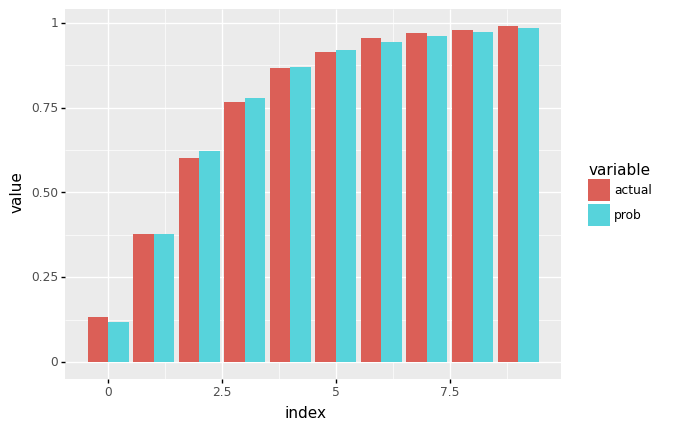

<ggplot: (8783921115109)>

In [91]:
df_bin['decile'] = pd.qcut(df_bin['prob'],q=10)
deciles = df_bin.groupby('decile')[['prob','y_bin']].mean().reset_index()
deciles['index'] = np.arange(len(deciles))
decile_probs = deciles[['prob','index']].rename(columns={"prob":"value"})
decile_probs['variable'] = 'prob'
decile_actuals = deciles[['y_bin','index']].rename(columns={"y_bin":"value"})
decile_actuals['variable'] = 'actual'
deciles = pd.concat([decile_probs,decile_actuals],axis=0)
(ggplot(deciles,aes(x='index',y='value',fill='variable')) +
 geom_bar(stat='identity',position='dodge')
)

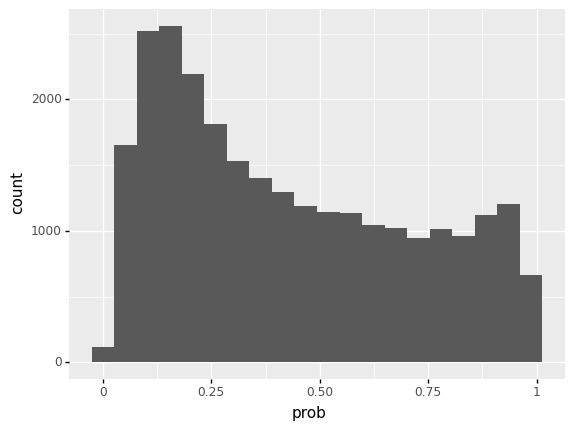

<ggplot: (8783923655879)>

In [183]:
(ggplot(df_bin.query('y_bin==0'),aes(x='prob')) +
geom_histogram(bins=20))

In [156]:
# Identify the ones with high-prob that are zeros (where we're overpredicting)
df_bin.query("prob>=.75&y_bin==0").groupby(["time_control","rating_latest_rounded_300","target_rating_gain_rounded"]).size().sort_values(ascending=False).head(10)

time_control  rating_latest_rounded_300  target_rating_gain_rounded
Blitz         1800                       200                           237
Rapid         2100                       100                           234
              1800                       100                           231
Blitz         1500                       200                           225
              2100                       100                           223
              1800                       100                           192
Bullet        1800                       100                           184
              1500                       100                           184
              1200                       100                           163
              2100                       100                           160
dtype: int64

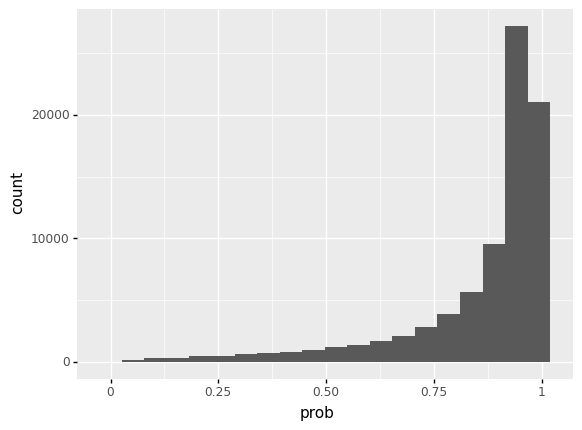

<ggplot: (8783920203617)>

In [93]:
(ggplot(df_bin.query('y_bin==1'),aes(x='prob')) +
geom_histogram(bins=20))

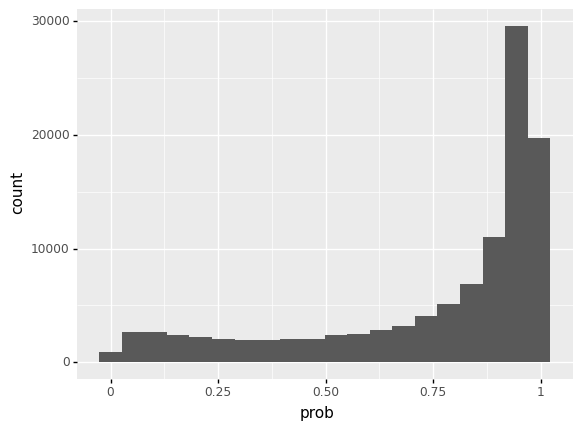

<ggplot: (8783920198982)>

In [94]:
(ggplot(df_bin,aes(x='prob')) +
geom_histogram(bins=20))

In [186]:
df_bin['rating_latest_rounded_200'] = 200*np.ceil(df_bin['rating_latest_rounded']/200).astype(int)
df_bin['rating_latest_rounded_300'] = 300*np.ceil(df_bin['rating_latest_rounded']/300).astype(int)
xtabs_bin = df_bin.groupby(['time_control','target_rating_gain_rounded','rating_latest_rounded_200'])[['y_bin','prob']].agg([np.mean,len]).iloc[:,:-1].round(2)
xtabs_bin.columns = ['prop_actual','n','mean_prob']
xtabs_bin.reset_index(inplace=True)
xtabs_bin['diff'] = xtabs_bin['mean_prob'] - xtabs_bin['prop_actual']
xtabs_bin['abs_diff'] = xtabs_bin['diff'].abs()
xtabs_bin.query("n>=50").sort_values("abs_diff",ascending=False).head(10)

,time_control,target_rating_gain_rounded,rating_latest_rounded_200,prop_actual,n,mean_prob,diff,abs_diff
48,Blitz,400,1000,0.46,63,0.71,0.25,0.25
21,Blitz,100,2600,0.67,79,0.87,0.20,0.20
99,Bullet,200,2600,0.32,68,0.46,0.14,0.14
103,Bullet,300,1000,0.64,129,0.77,0.13,0.13
56,Blitz,500,1000,0.39,75,0.48,0.09,0.09
38,Blitz,300,1200,0.70,411,0.78,0.08,0.08
207,Rapid,100,2400,0.68,93,0.76,0.08,0.08
37,Blitz,300,1000,0.80,136,0.88,0.08,0.08
154,Classical,200,1400,0.59,324,0.51,-0.08,0.08
164,Classical,300,1400,0.39,194,0.32,-0.07,0.07


In [192]:
df_bin.groupby(['rating_latest_rounded_200'])[['y_bin','prob']].agg([np.mean,len]).iloc[:,:-1].round(2)


y_bin         prob
                           mean    len  mean
rating_latest_rounded_200                   
600                        1.00     20  0.92
800                        0.80    490  0.88
1000                       0.81   3510  0.85
1200                       0.80   9715  0.81
1400                       0.77  15830  0.77
1600                       0.76  23355  0.75
1800                       0.75  24205  0.74
2000                       0.74  18830  0.74
2200                       0.71   8855  0.73
2400                       0.68   2720  0.72
2600                       0.60    560  0.69
2800                       0.52    110  0.68
3000                       0.00      5  0.34

In [193]:
df_bin.groupby(['target_rating_gain_rounded'])[['y_bin','prob']].agg([np.mean,len]).iloc[:,:-1].round(2)


y_bin         prob
                            mean    len  mean
target_rating_gain_rounded                   
0                           0.97  28325  0.97
100                         0.91  37183  0.91
200                         0.67  19905  0.66
300                         0.40  13367  0.40
400                         0.24   5241  0.24
500                         0.22   2107  0.23
600                         0.13   2077  0.13

In [187]:
xtabs_bin.query("time_control=='Blitz'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded_200',values='prop_actual').iloc[:-1,2:-2]

rating_latest_rounded_200,1000,1200,1400,1600,1800,2000,2200,2400
target_rating_gain_rounded,,,,,,,,
0,0.99,0.99,1.00,0.99,0.99,0.99,0.99,0.99
100,0.96,0.97,0.96,0.96,0.96,0.95,0.90,0.84
200,0.88,0.88,0.84,0.79,0.74,0.65,0.50,0.37
300,0.80,0.70,0.67,0.53,0.40,0.28,0.14,0.08
400,0.46,0.51,0.39,0.25,0.10,0.08,NaN,NaN
500,0.39,0.35,0.21,0.12,NaN,NaN,NaN,NaN


In [188]:
xtabs_bin.query("time_control=='Blitz'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded_200',values='mean_prob').iloc[:-1,2:-2]

rating_latest_rounded_200,1000,1200,1400,1600,1800,2000,2200,2400
target_rating_gain_rounded,,,,,,,,
0,0.99,0.99,0.99,0.99,0.99,0.98,0.98,0.98
100,0.99,0.98,0.97,0.96,0.95,0.94,0.92,0.90
200,0.95,0.91,0.85,0.79,0.72,0.63,0.53,0.44
300,0.88,0.78,0.66,0.52,0.39,0.27,0.18,0.11
400,0.71,0.53,0.35,0.21,0.12,0.09,NaN,NaN
500,0.48,0.30,0.17,0.10,NaN,NaN,NaN,NaN


In [189]:
xtabs_bin.query("time_control=='Blitz'").pivot(index='target_rating_gain_rounded',columns='rating_latest_rounded_200',values='diff').iloc[:-1,2:-2]

rating_latest_rounded_200,1000,1200,1400,1600,1800,2000,2200,2400
target_rating_gain_rounded,,,,,,,,
0,0.00,0.00,-0.01,0.00,0.00,-0.01,-0.01,-0.01
100,0.03,0.01,0.01,0.00,-0.01,-0.01,0.02,0.06
200,0.07,0.03,0.01,0.00,-0.02,-0.02,0.03,0.07
300,0.08,0.08,-0.01,-0.01,-0.01,-0.01,0.04,0.03
400,0.25,0.02,-0.04,-0.04,0.02,0.01,NaN,NaN
500,0.09,-0.05,-0.04,-0.02,NaN,NaN,NaN,NaN


## Regression Evaluation

In [34]:
df_cont['pred'] = ols.predict(df_cont)
#df_cont.loc[df_cont['pred']<0,'pred'] = 0
df_cont['pred'].describe()

count    81678.000000
mean       190.402299
std        112.919489
min       -168.758979
25%        107.379062
50%        166.878672
75%        258.375054
max        619.006178
Name: pred, dtype: float64

In [35]:
len(df_cont[df_cont['pred']<0])/len(df_cont)

0.007664242513283871

In [36]:
df_cont['error'] = df_cont['pred']-df_cont['y_cont']
df_cont['abs_error'] = df_cont['error'].abs()

In [37]:
df_cont['error'].describe().round()

count    81678.0
mean        -0.0
std        159.0
min       -738.0
25%        -65.0
50%         41.0
75%        102.0
max        537.0
Name: error, dtype: float64

In [38]:
df_cont['abs_error'].describe().round()

count    81678.0
mean       120.0
std        104.0
min          0.0
25%         48.0
50%         93.0
75%        159.0
max        738.0
Name: abs_error, dtype: float64

In [39]:
error_summary = df_cont.groupby(['target_rating_gain_rounded','rating_latest_rounded','time_control'])[['pred','y_cont','abs_error','error']].agg([np.mean]).round().astype(int)
sizes = df_cont.groupby(['target_rating_gain_rounded','rating_latest_rounded','time_control']).size().reset_index()
sizes.rename(columns={0:"n"},inplace=True)
error_summary.columns = ['mean_pred','mean_actual','mean_abs_error','mean_error']
error_summary = error_summary.reset_index().merge(sizes,on=['target_rating_gain_rounded','rating_latest_rounded','time_control'])
error_summary = error_summary.query('n>30')
error_summary.sort_values("mean_error",ascending=False).head()

,target_rating_gain_rounded,rating_latest_rounded,time_control,mean_pred,mean_actual,mean_abs_error,mean_error,n
343,400,1700,Bullet,353,485,236,-132,34
295,300,2200,Blitz,391,522,222,-132,31
291,300,2100,Blitz,399,508,215,-109,55
225,200,2300,Blitz,324,407,213,-83,70
230,200,2400,Bullet,248,300,211,-52,34


In [40]:
df_cont.groupby("time_control")['abs_error'].mean().round()

time_control
Blitz        117.0
Bullet       113.0
Classical    128.0
Rapid        136.0
Name: abs_error, dtype: float64

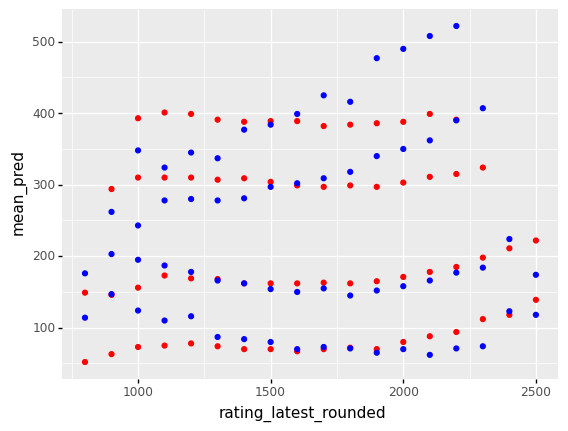

<ggplot: (8783920867175)>

In [41]:
(ggplot(error_summary.query("time_control=='Blitz'&target_rating_gain_rounded<=300")) +
geom_point(aes(x='rating_latest_rounded',y='mean_pred'),color='red')+
 geom_point(aes(x='rating_latest_rounded',y='mean_actual'),color='blue')
)

## Features
- Target time control (likely interacted with various other features)
- Target rating gain
- Current rating (likely nonlinear relationship)
- Rating growth in last 30 days / 90 days / 180 days
- Rating volatility measures
- Peak historical rating relative to current rating
- Rating in other time controls + puzzles
- Rating growth in other time controls + puzzles
- Difference between other time control ratings + target time control rating
- How long you've been on lichess
- How many games you've played (ever, and within last 30 days, and within the target time control - if you haven't played many it could mean more uncertainty). Consider that most discord bot users will have played more recent rated games in the target time control than the typical user in the training data. 
- Last time you played a rated game in the target time control (if it's a long time ago, it could mean more uncertainty)

## Outcomes
- Will you ever achieve a rating that's X rating points higher than your current rating in the next Y months (X is calculated from target rating submitted by user, Y = 24?)
- If so, when will you first reach the target rating? (point estimate + prediction interval of dates) - use number of days as outcome, then transform to date for the bot message
- Try to tweak model to avoid negative predictions, and manually override when needed. Same with predictions greater than 2 years out.


## Notes:
- Use cross-validation since sample size might be constrained
- Need to impute nulls
- Need to write code for scoring based on discord input (including lichess API querying)
- Need to figure out how to make prediction interval
- Add more comments + documentation to final version
